# AdventureWorks Försäljningsanalys
I denna analys undersöker vi AdventureWorks-databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Vi använder SQL för att hämta data och Python för visualisering och analys.

In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Password12345")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\gipch\AppData\Local\Temp\ipykernel_9256\3806746930.py:22: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [12]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori
Affärsfråga: Hur många produkter finns i varje kategori?

Tabeller som använts:
Production.ProductCategory
Production.ProductSubCategory
Production.Product

Plan:
JOINA tabellerna
Räkna DISTINCT produkter per kategori
Skapa ett vertikalt stapeldiagram
Analysera resultatet

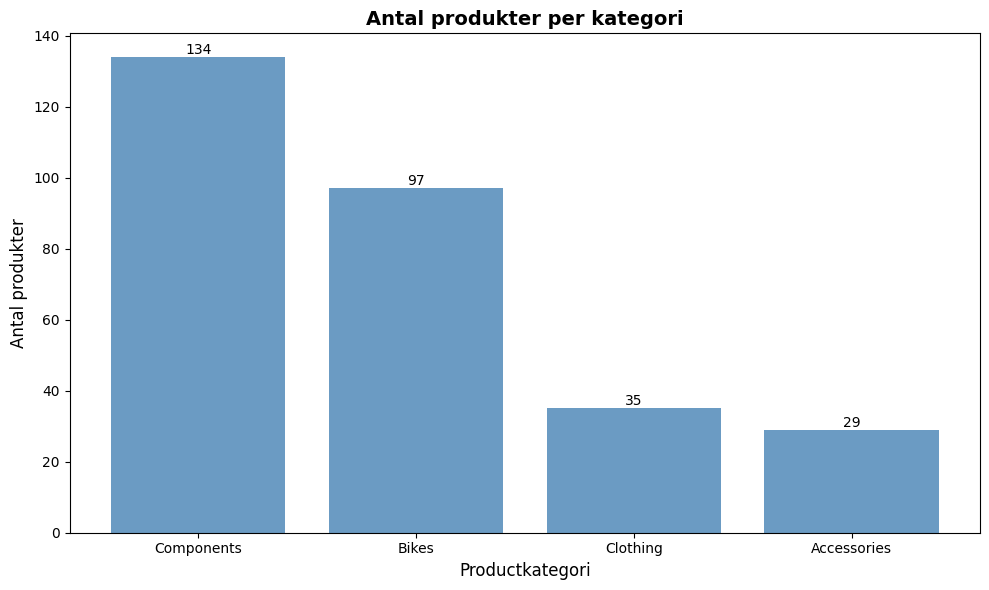

In [13]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount

FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)



fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='steelblue', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )



ax.set_xlabel('Productkategori', fontsize=12)
ax.set_ylabel('Antal produkter', fontsize=12)
ax.set_title('Antal produkter per kategori', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### Insikter - Antal produkter per kategori
Components är en största kategorin med 134 produkter.
Accessoarer är minst med 29 produkter.

Dettta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar.
Och att accessoarerkan vara ett utvecklingsområde.

## Visualisering 2: Total försäljning per produktkategori
Affärsfråga: Vilka produktkategorier genererar mest intäkter?

Tabeller som använts: 
Production.ProductCategory
Production.ProductSubcategory
Production.Product
Sales.SalesOrderDetail

Metod: 
Joina kategori → subkategori → produkt → orderrader Summera LineTotal per kategori.
Sortera högst till lägst försäljninng
Skapa ett horisontellt stapeldiagram
Beskriv vilken kategori som är störst/minst

In [14]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc 
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p 
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod
    ON sod.ProductID = p.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC
"""
df_vis2 = query_df(query_vis2)
df_vis2.head()



,CategoryName,TotalSales
0,Bikes,9.465117e+07
1,Components,1.180259e+07
2,Clothing,2.120543e+06
3,Accessories,1.272073e+06


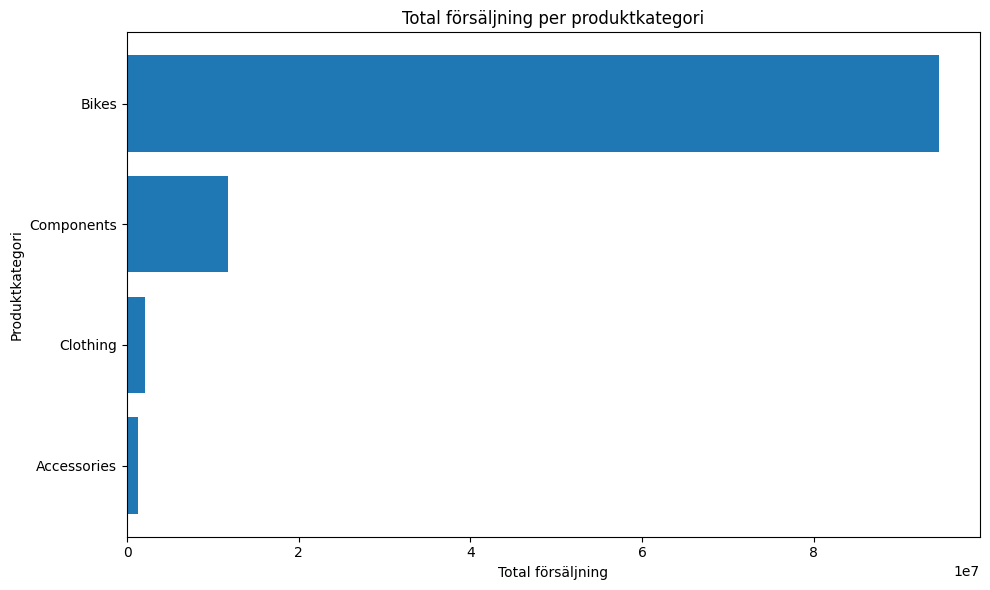

In [15]:
df_plot = df_vis2.sort_values("TotalSales", ascending=True)

fig, ax = plt.subplots(figsize=(10,6))
ax.barh(df_plot["CategoryName"], df_plot["TotalSales"])

ax.set_title("Total försäljning per produktkategori")
ax.set_xlabel("Total försäljning")
ax.set_ylabel("Produktkategori")

plt.tight_layout()
plt.show()



In [16]:
top = df_vis2.iloc[0]
bottom = df_vis2.iloc[-1]
top, bottom


(CategoryName              Bikes
 TotalSales      94651172.704731
 Name: 0, dtype: object,
 CategoryName       Accessories
 TotalSales      1272072.883926
 Name: 3, dtype: object)

### Insikter – Total försäljning per produktkategori

Störst kategori: Bikes med 94651172.704731 i total försäljning.

Minst kategori: Accessories med 1272072.883926 i total försäljning.

## Visualisering 3: Försäljningstrend per månad
Affärsfråga: Hur har försäljningen utvecklats över tid?

Tabeller som används:

Sales.SalesOrderHeader

Plan:

Hämta total försäljning per månad (SQL: GROUP BY månad)
Sortera kronologiskt (äldst först)
Visa minst 12 månader data
Skapa linjediagram
Hitta högsta och lägsta månad och beskriv trenden

In [17]:
query_vis3 = """
SELECT
    DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1) AS MonthStart,
    SUM(SubTotal) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1)
ORDER BY MonthStart;
"""
df_vis3 = query_df(query_vis3)
df_vis3.head()


,MonthStart,TotalSales
0,2022-05-01,5.177374e+05
1,2022-06-01,2.001279e+06
2,2022-07-01,1.668510e+06
3,2022-08-01,1.326138e+06
4,2022-09-01,2.836410e+06


In [18]:
df_vis3["MonthStart"] = pd.to_datetime(df_vis3["MonthStart"])

# minst 12 månader (tar senaste 12)
df_12 = df_vis3.tail(12).copy()
df_12


,MonthStart,TotalSales
26,2024-07-01,4.918580e+06
27,2024-08-01,3.325296e+06
28,2024-09-01,4.539829e+06
29,2024-10-01,4.820725e+06
30,2024-11-01,3.291238e+06
31,2024-12-01,4.082854e+06
32,2025-01-01,4.276428e+06
33,2025-02-01,3.565879e+06
34,2025-03-01,4.987902e+06
35,2025-04-01,5.222759e+06


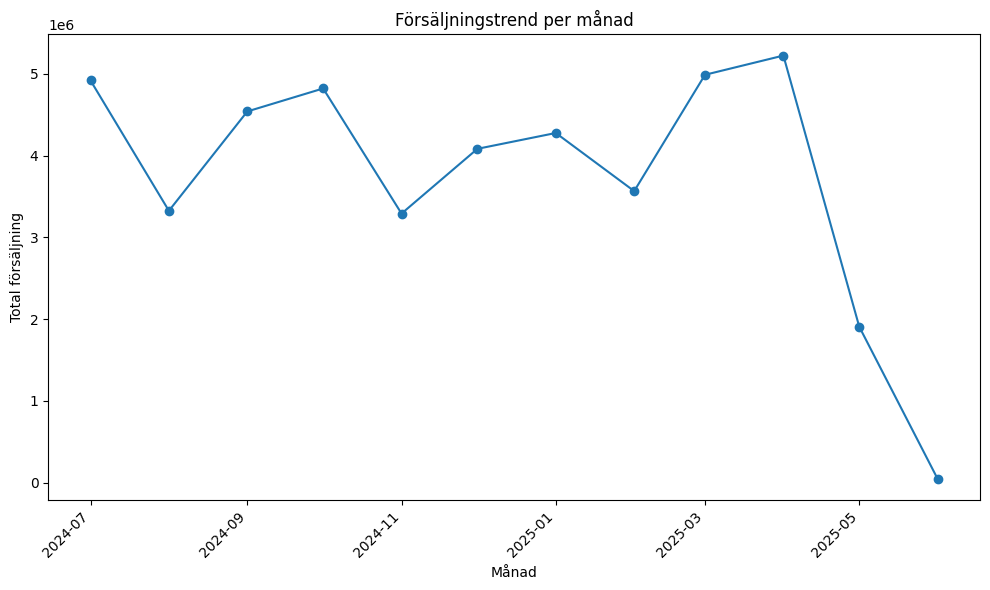

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_12["MonthStart"], df_12["TotalSales"], marker="o")

ax.set_title("Försäljningstrend per månad")
ax.set_xlabel("Månad")
ax.set_ylabel("Total försäljning")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [20]:
max_row = df_12.loc[df_12["TotalSales"].idxmax()]
min_row = df_12.loc[df_12["TotalSales"].idxmin()]

print("Högsta månad:", max_row["MonthStart"].strftime("%Y-%m"), f"= {max_row['TotalSales']:,.0f}")
print("Lägsta månad:", min_row["MonthStart"].strftime("%Y-%m"), f"= {min_row['TotalSales']:,.0f}")


Högsta månad: 2025-04 = 5,222,759
Lägsta månad: 2025-06 = 47,492


### Insikter – Försäljningstrend per månad

Försäljningen varierar mellan månader, med en tydlig topp under våren.

Högsta månaden är 2025-04 med 5,222,759 i total försäljning.

Lägsta månaden är 2025-06 med 47,492 i total försäljning.

Den kraftiga nedgången i sista månaden kan tyda på att månaden är ofullständig (inte hela månaden finns med i datat), så trenden bör tolkas med försiktighet

## Visualisering 4: Försäljning och antal ordrar per år

Affärsfråga: Hur ser total försäljning och antal ordrar ut per år?

Tabeller som används:

Sales.SalesOrderHeader

Plan:

Gruppera data per år (YEAR(OrderDate))
Beräkna total försäljning (SUM(SubTotal))
Räkna antal ordrar (COUNT(SalesOrderID))
Sortera åren kronologiskt
Skapa grupperat stapeldiagram med två staplar per år
Jämför vilket år som har högst försäljning och om orderantal följer samma trend

In [21]:
query_vis4 = """
SELECT
    YEAR(OrderDate) AS OrderYear,
    SUM(SubTotal) AS TotalSales,
    COUNT(SalesOrderID) AS OrderCount
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear;
"""
df_vis4 = query_df(query_vis4)
df_vis4


,OrderYear,TotalSales,OrderCount
0,2022,1.456105e+07,1692
1,2023,3.160492e+07,3830
2,2024,4.367189e+07,14244
3,2025,2.000852e+07,11699


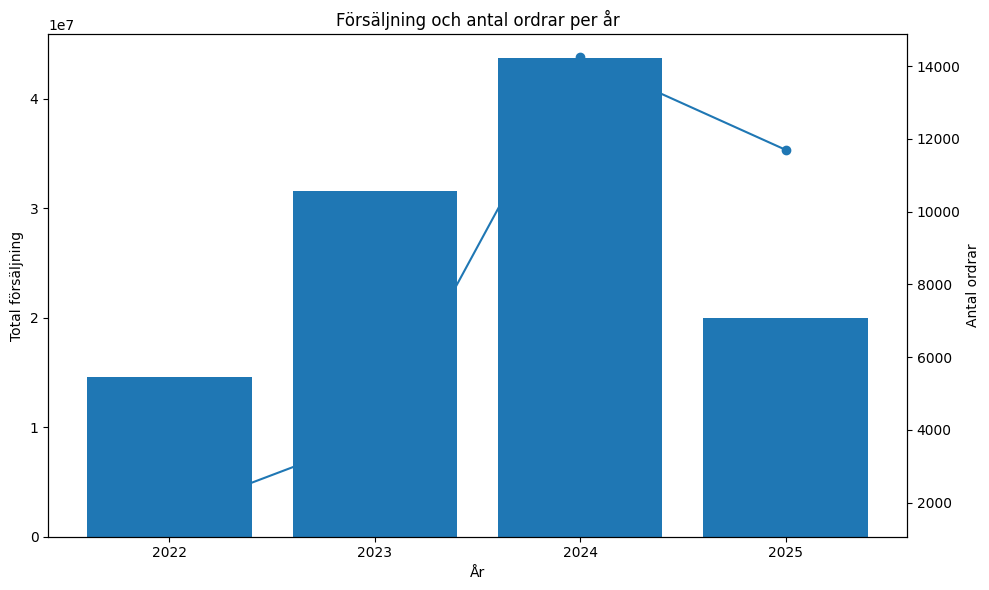

In [22]:
fig, ax1 = plt.subplots(figsize=(10,6))

x = df_vis4["OrderYear"].astype(str)
ax1.bar(x, df_vis4["TotalSales"])
ax1.set_title("Försäljning och antal ordrar per år")
ax1.set_xlabel("År")
ax1.set_ylabel("Total försäljning")

ax2 = ax1.twinx()
ax2.plot(x, df_vis4["OrderCount"], marker="o")
ax2.set_ylabel("Antal ordrar")

plt.tight_layout()
plt.show()


In [23]:
max_sales = df_vis4.loc[df_vis4["TotalSales"].idxmax()]
max_orders = df_vis4.loc[df_vis4["OrderCount"].idxmax()]

print("Högst försäljning:", int(max_sales["OrderYear"]), f"= {max_sales['TotalSales']:,.0f}")
print("Flest ordrar:", int(max_orders["OrderYear"]), f"= {max_orders['OrderCount']:,}")


Högst försäljning: 2024 = 43,671,890
Flest ordrar: 2024 = 14,244.0


### Insikter – Försäljning och antal ordrar per år

Året med högst försäljning är 2024 med 43,671,890 i total försäljning.

Året med flest ordrar är 2024 med 14,244.0 ordrar.

Både försäljning och antal ordrar ökar från 2022 till 2024, vilket tyder på stark tillväxt.
År 2025 är lägre än 2024, vilket kan bero på att året är ofullständigt i datat (inte hela året finns med).

Om försäljningen ökar mer än orderantalet kan det tyda på högre genomsnittligt ordervärde.